### Statistical Physics Winter School 2018
#### Fisher Discriminant Analysis
- Author: Yung-Kyun Noh

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
datanum1 = 300
datanum2 = 300
datanum3 = 300
Dim = 1000

- Data generation

In [3]:
# True papameters
meanScale = 1.5
m1 = np.random.randn(Dim)*meanScale
m2 = np.random.randn(Dim)*meanScale
m3 = np.random.randn(Dim)*meanScale

S1 = np.random.randn(Dim,Dim)
S1 = np.dot(S1.T, S1)
S2 = S1
S3 = S1

# data generation
data1 = np.random.multivariate_normal(m1, S1, datanum1)
data2 = np.random.multivariate_normal(m2, S2, datanum2)
data3 = np.random.multivariate_normal(m3, S3, datanum3)
print data1.shape
print data2.shape
print data3.shape

(300, 1000)
(300, 1000)
(300, 1000)


- Parameter estimation assuming we do not have any information about the true parameters

In [4]:
estM1 = np.sum(data1, axis = 0)/datanum1
estM2 = np.sum(data2, axis = 0)/datanum2
estM3 = np.sum(data3, axis = 0)/datanum3
estS1 = np.dot(data1.T, data1)/datanum1 - np.outer(estM1, estM1)
estS2 = np.dot(data2.T, data2)/datanum2 - np.outer(estM2, estM2)
estS3 = np.dot(data3.T, data3)/datanum3 - np.outer(estM3, estM3)
print np.linalg.matrix_rank(estS1)
print np.linalg.matrix_rank(estS2)
print np.linalg.matrix_rank(estS3)


299
299
299


### Fisher Discriminant Analysis with estimated means $\mu_c$ and covariances $S_c$ for $c = 1,2,3$.
\begin{eqnarray}
\mathbf{w} = \arg\max_\mathbf{w}\frac{\mathbf{w}^\top S_B\mathbf{w}}{\mathbf{w}^\top S_W\mathbf{w}}
\end{eqnarray}
\begin{eqnarray}
S_B &=& \text{Cov}(\mu_c) \\
S_W &=& \frac{S_1 + S_2 + S_3}{3}
\end{eqnarray}
From data, extract the $\mathbf{w}$ component by dlflation and continue obtaining the next $\mathbf{w}$ repeatedly.

In [5]:
numClasses = 3
totM = (estM1 + estM2 + estM3)/numClasses
S_B = (np.outer(estM1,estM1) + np.outer(estM2,estM2) + np.outer(estM3,estM3))/numClasses - np.outer(totM,totM)
S_W = (estS1 + estS2 + estS3)/numClasses

# regularization
regConst = -9
S_W = S_W + np.trace(S_W)*np.power(10., regConst)*np.eye(Dim)


In [6]:
S_B = (S_B + S_B.T)/2
S_W = (S_W + S_W.T)/2
eigvals, eigvecs = scipy.linalg.eigh(S_B, S_W, eigvals_only=False)


In [7]:
print np.dot(eigvecs.T[-1], np.dot(S_W, eigvecs.T[-1]))

0.99999999997


In [8]:
#print np.argmax(eigvals)
sortedEigIdxes = np.argsort(eigvals)
projectVecs = eigvecs.T[sortedEigIdxes[[-1,-2]]]
print sortedEigIdxes[[-1,-2]]
print eigvals[sortedEigIdxes[[-1,-2]]]

[999 998]
[ 97448.2294783   80805.28470549]


In [9]:
def draw_projected_data(projectVecs, data1, data2, data3):
    plt.rcParams['figure.figsize']=(5,5)
    projData1 = np.dot(data1, projectVecs.T)
    projData2 = np.dot(data2, projectVecs.T)
    projData3 = np.dot(data3, projectVecs.T)
    plt.scatter(projData1[:,0],projData1[:,1],30,'r')
    plt.scatter(projData2[:,0],projData2[:,1],30,'b')
    plt.scatter(projData3[:,0],projData3[:,1],30,'g')
    [x1min,x1max,x2min,x2max] = plt.axis()
    x1val = np.arange(x1min,x1max,0.1)
    
    plt.axis([x1min,x1max,x2min,x2max])
    plt.show()

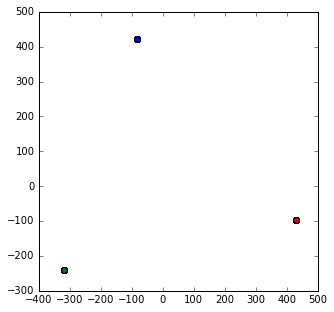

In [10]:
draw_projected_data(projectVecs, data1, data2, data3)

### Test with a new set of data 

- Generate a new set of data

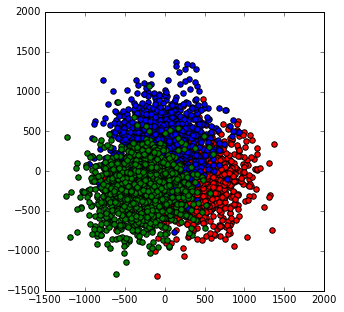

In [11]:
testdatanum = 1000
tstdata1 = np.random.multivariate_normal(m1, S1, testdatanum)
tstdata2 = np.random.multivariate_normal(m2, S2, testdatanum)
tstdata3 = np.random.multivariate_normal(m3, S3, testdatanum)
draw_projected_data(projectVecs, tstdata1, tstdata2, tstdata3)

- $k$-Nearest neighbor classification

In [12]:
knum = 5
TrData = np.concatenate([np.dot(data1, projectVecs.T),np.dot(data2, projectVecs.T),np.dot(data3, projectVecs.T)])
TrLabels = np.concatenate([np.ones(datanum1), np.ones(datanum2)*2, np.ones(datanum3)*3])

In [13]:
TstData = np.concatenate([np.dot(tstdata1, projectVecs.T), np.dot(tstdata2, projectVecs.T), np.dot(tstdata3, projectVecs.T)])
TstLabels = np.concatenate([np.ones(testdatanum), np.ones(testdatanum)*2, np.ones(testdatanum)*3])

In [14]:
Distances = np.outer(np.ones(testdatanum*numClasses), np.diag(np.dot(TrData,TrData.T))) + \
    np.outer(np.diag(np.dot(TstData,TstData.T)), np.ones(datanum1 + datanum2 + datanum3)) - \
    2*np.dot(TstData, TrData.T)
sortedDistanceIdxes = np.argsort(Distances, axis=1)

print TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]]


[[ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.]
 ..., 
 [ 3.  3.  3.  3.  3.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]


In [15]:
ClassifiedLabels = argmax([sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 1, axis=1), \
                        sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 2, axis=1), \
                        sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 3, axis=1)], axis=0) + 1
accuracy = sum(ClassifiedLabels == TstLabels)/(1.*testdatanum*numClasses)
print accuracy

0.765333333333


- $k$-nearest neighbor classification with original data

In [16]:
TrData = np.concatenate([data1,data2,data3])
TrLabels = np.concatenate([np.ones(datanum1), np.ones(datanum2)*2, np.ones(datanum3)*3])
print TrData.shape

TstData = np.concatenate([tstdata1,tstdata2,tstdata3])
TstLabels = np.concatenate([np.ones(testdatanum), np.ones(testdatanum)*2, np.ones(testdatanum)*3])

Distances = np.outer(np.ones(testdatanum*numClasses), np.diag(np.dot(TrData,TrData.T))) + \
    np.outer(np.diag(np.dot(TstData,TstData.T)), np.ones(datanum1 + datanum2 + datanum3)) - \
    2*np.dot(TstData, TrData.T)
sortedDistanceIdxes = np.argsort(Distances, axis=1)

ClassifiedLabels = argmax([sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 1, axis=1), \
                        sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 2, axis=1), \
                        sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 3, axis=1)], axis=0) + 1
accuracy = sum(ClassifiedLabels == TstLabels)/(1.*testdatanum*numClasses)
print accuracy


(900, 1000)
0.391333333333


### Optimize regularization

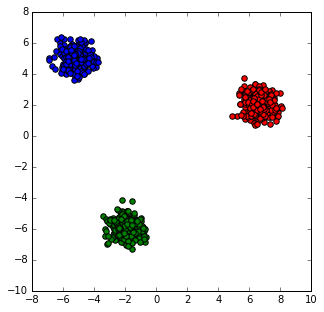

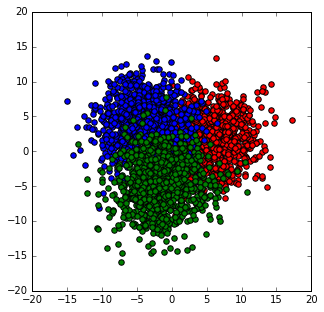

0.845333333333


In [17]:
totM = (estM1 + estM2 + estM3)/numClasses
S_B = (np.outer(estM1,estM1) + np.outer(estM2,estM2) + np.outer(estM3,estM3))/numClasses - np.outer(totM,totM)
S_W = (estS1 + estS2 + estS3)/numClasses

# regularization
regConst = -5
S_W = S_W + np.trace(S_W)*np.power(10., regConst)*np.eye(Dim)

S_B = (S_B + S_B.T)/2
S_W = (S_W + S_W.T)/2
eigvals, eigvecs = scipy.linalg.eigh(S_B, S_W, eigvals_only=False)

sortedEigIdxes = np.argsort(eigvals)
projectVecs = eigvecs.T[sortedEigIdxes[[-1,-2]]]

draw_projected_data(projectVecs, data1, data2, data3)
draw_projected_data(projectVecs, tstdata1, tstdata2, tstdata3)

knum = 5
TrData = np.concatenate([np.dot(data1, projectVecs.T),np.dot(data2, projectVecs.T),np.dot(data3, projectVecs.T)])
TrLabels = np.concatenate([np.ones(datanum1), np.ones(datanum2)*2, np.ones(datanum3)*3])
TstData = np.concatenate([np.dot(tstdata1, projectVecs.T), np.dot(tstdata2, projectVecs.T), np.dot(tstdata3, projectVecs.T)])
TstLabels = np.concatenate([np.ones(testdatanum), np.ones(testdatanum)*2, np.ones(testdatanum)*3])

Distances = np.outer(np.ones(testdatanum*numClasses), np.diag(np.dot(TrData,TrData.T))) + \
    np.outer(np.diag(np.dot(TstData,TstData.T)), np.ones(datanum1 + datanum2 + datanum3)) - \
    2*np.dot(TstData, TrData.T)
sortedDistanceIdxes = np.argsort(Distances, axis=1)

ClassifiedLabels = argmax([sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 1, axis=1), \
                        sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 2, axis=1), \
                        sum(TrLabels[sortedDistanceIdxes[:,np.arange(0,knum)]] == 3, axis=1)], axis=0) + 1
accuracy = sum(ClassifiedLabels == TstLabels)/(1.*testdatanum*numClasses)
print accuracy
